In [3]:
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

  Using cached torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (776.8 MB)
  Using cached pytorch_lightning-1.2.2-py3-none-any.whl (816 kB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.10
    Uninstalling pytorch-lightning-1.5.10:
      Successfully uninstalled pytorch-lightning-1.5.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.9.1 requires torch==1.8.1, but you have torch 1.7.1 which is incompatible.
torchaudio 0.9.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
lightning-bolts 0.5.0 requires pytorch-lightning>=1.4.0, but you have pytorch-lightning 1.2.2 which is incompatible.


In [4]:
import os

import torch
import torch.nn.functional as F
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision import transforms

# Note - you must have torchvision installed for this example
from torchvision.datasets import CIFAR10, MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

In [7]:
class LitModel(LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.channels = channels
        self.width = width
        self.height = height
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [8]:
class CIFAR10DataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        self.dims = (3, 32, 32)
        self.num_classes = 10

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE)

In [11]:
dm = CIFAR10DataModule()
model = LitModel(*dm.size(), dm.num_classes, hidden_size=256)
trainer = Trainer(
    max_epochs=50,
    progress_bar_refresh_rate=20,
    gpus=AVAIL_GPUS,
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 855 K 
-------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.420     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [12]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [13]:
! tensorboard --logdir=runs --load_fast=false --bind_all

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.8.0 at http://labserver:6007/ (Press CTRL+C to quit)
^C


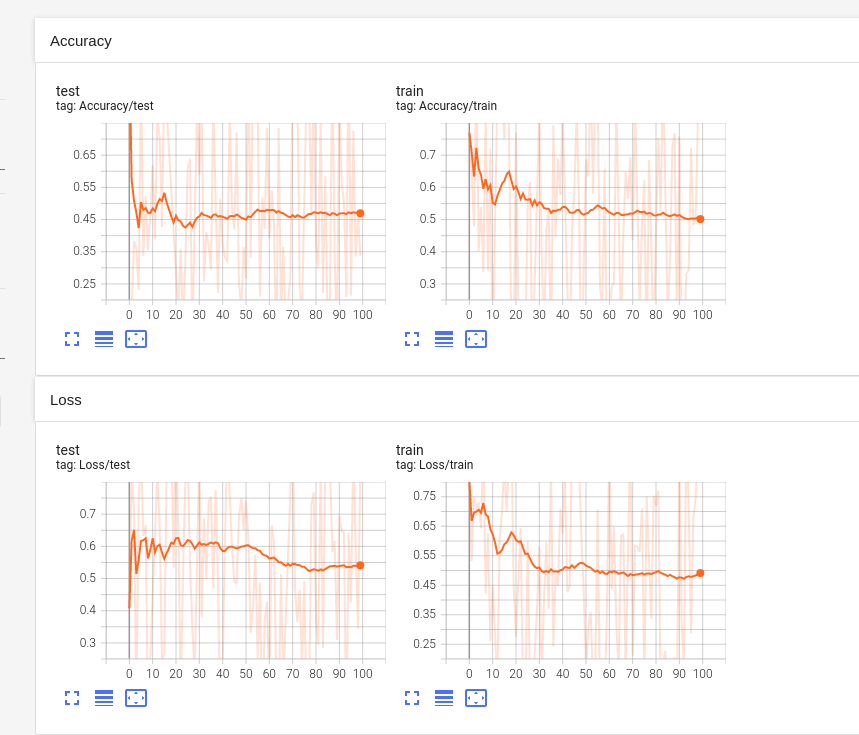